# Audience judgements of motion

Consider how participants moved during the concert and how these compare to their ratings of their own and each others (neighbours) movements during music listening.

1. Pull up the motion measurements and segment per piece (remote and hall?)
2. Pull up Questionnaire responses about how they moved
3. Check summary stats on movement behaviour relative to ratings per question
4. Rank motion by participants, can we see what a lot of movement looks like, vs a little?

In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

In [2]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [3]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [4]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [5]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [6]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
#concert_times.iloc[50:75]

In [7]:
concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [8]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only participants with aligned motion traces and questionnair responses
partDets = partDets.loc[partDets['Questionnaire_Language'].isin(['D','E']),:] # participants with at least some questionnaire responses
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,ADQ001,1,A,D,Q,0,6.0,NaN,NaN,NaN,0.14,0.16,0.0
1,ADQ002,2,A,D,Q,0,3.0,NaN,NaN,NaN,NaN,-0.36,0.0
2,ADQ003,3,A,D,Q,0,2.0,NaN,NaN,NaN,0.88,1.02,0.0
3,ADQ004,4,A,D,Q,0,4.0,NaN,NaN,NaN,0.44,0.62,1.0
4,ADQ005,5,A,D,Q,0,4.0,NaN,NaN,NaN,0.04,0.12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ115,115,B,E,Q,0,NaN,Porto,41.0,-9.0,-6.32,NaN,1.0
108,BEQ116,116,B,E,Q,0,NaN,Montréal,46.0,-74.0,-30.66,NaN,1.0
109,BEQ117,117,B,E,Q,0,NaN,Stockholm,59.0,17.0,-10.22,NaN,1.0
110,BEQ118,118,B,E,Q,0,NaN,Portola Valley California,37.0,-122.0,-28.00,NaN,0.0


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [9]:
# recalibrated to Events_Main_extra_tags.csv
Event_ranges = {'Beethoven':[6,10],'Schnittke':[15,18],'Bach':[25,26]}
Event_ranges = {'Folk 1':[30,31],'Folk 2':[32,33],'Folk 3':[35,36],'Folk 4':[38,39],'Folk 5':[41,42],'Folk 6':[47,48]}

ev = 'Folk 1'
Main_concert_times.iloc[Event_ranges[ev][0]:Event_ranges[ev][1],:]

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,Shorter_tag,sequence
Datetime,,,,,,,,
2021-10-26 19:32:37,6271.28,6271280,Folk 1,Music,7908.52,487.68,Folk 1,30


In [10]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b.copy()*6 
    else:
        aud_df[part] = b.copy()
#     if np.nanmedian(b)>0:
#         aud_df[part] = b/np.nanmedian(b)
#     else:
#         aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct
ori_aud_df = aud_df.copy()
ori_aud_df.index = (ts_ct/1000).round(1)

print(time.time()-tic)

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


99.9521222114563


In [11]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)

In [12]:
aud_df.index = (ts_ct/1000).round(1)
aud_df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ110,BEQ111,BEQ112,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119
-1086.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.8,0.740777,0.467856,0.212834,0.101379,0.234912,0.224302,0.486310,0.064859,0.247404,0.237059,...,NaN,0.011573,0.063270,0.032345,NaN,NaN,NaN,NaN,0.227207,NaN
-1085.7,0.691307,0.179505,0.349901,0.100000,0.249657,0.184666,0.597926,0.055355,0.543207,0.371191,...,NaN,0.006860,0.036510,0.010653,NaN,NaN,NaN,NaN,0.183257,NaN
-1085.6,0.711500,0.137325,0.154668,0.063158,0.181522,0.134561,0.456580,0.072090,0.082915,1.156659,...,NaN,0.004449,0.029909,0.017225,NaN,NaN,NaN,NaN,0.140195,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9714.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9714.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9714.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#aligned_Part_Codes[:85], aligned_Part_Codes[85:]
AUD = aud_df.loc[:,aligned_Part_Codes[:85]].copy()
AUD['Virtual'] = np.nan
AUD['Virtual.'] = np.nan
AUD['Virtual..'] = np.nan
AUD['Virtual...'] = np.nan
AUD['Virtual....'] = np.nan
AUD = pd.concat([AUD,aud_df.loc[:,aligned_Part_Codes[85:]].copy()],axis=1)

In [14]:
concert_times.iloc[0,:]

Datetime          2021-10-26 17:36:35
Time_s                        -691.24
Time_ms                       -691240
Event                 Clapping for MC
Event_Type                   Applause
Time_Stream                     946.0
Event_Duration                  18.12
Shorter_tag                   Claps 0
sequence                            0
Name: 0, dtype: object

[-691.24, 8352.060000000001]


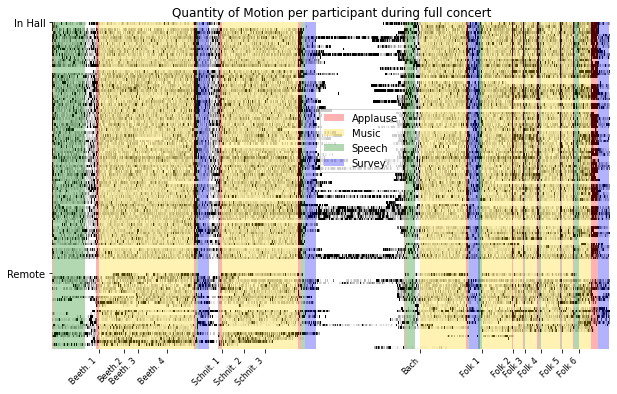

In [293]:
seg_start = concert_times.iloc[0,:].Time_s #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[49,:].Time_s + 200
print([seg_start,seg_end])
Event_Pallet={'Applause':'red','Music':'gold','Speech':'green','Survey':'blue','Synch':'purple'}

# seg_times = Main_concert_times.copy()
seg_df = AUD.loc[seg_start:seg_end]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [10,6])
chart = sns.heatmap(data=-seg_df.transpose(), ax=ax1,vmin=-0.4, vmax=0,cbar=False, cmap=cm.gray)

seg_times = concert_times.loc[concert_times['Event_Type'].isin(['Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
plt.xticks(new_xticks,seg_times.Shorter_tag, rotation='45',fontsize=8, ha='right')

seg_times = concert_times#.loc[concert_times['Event_Type'].isin(['Speech','Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
new_dur = len(seg_df)*(seg_times['Event_Duration'])/(seg_end -seg_start)
new_dur_survey = len(seg_df)*(180)/(seg_end -seg_start)
xrange = [0,180]

ax1.margins(0)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='red',label="Applause",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1,  facecolor='gold',label="Music",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='green',label="Speech",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='blue',label="Survey",alpha=alpha_factor)

ax1.legend(loc='upper left', bbox_to_anchor=(0.47,0.75))


alpha_factor = 0.3
yrange = [0,115.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = new_xticks[i]
    ej = new_xticks[i] + new_dur[i]
    if r['Event_Type'].startswith('Applause'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=alpha_factor)
    if r['Event_Type'].startswith('Musi'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='gold', alpha=alpha_factor)
    if r['Event_Type'].endswith('Speech'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=alpha_factor)
    if r['Event_Type'].startswith('Survey'):
        ej = new_xticks[i] + new_dur_survey
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=alpha_factor)

ax1.set_yticks([0,90])
ax1.set_yticklabels(['In Hall','Remote'])
# ax1.set_xticklabels(cmoments['Event'])
plt.title('Quantity of Motion per participant during full concert')
plt.savefig('./Plots/qom_n_full_colour.png', bbox_inches = 'tight',dpi = 300)
plt.show()


[-691.24, 8352.060000000001]


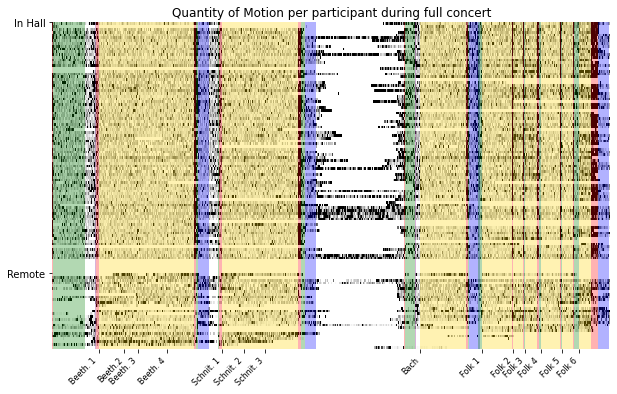

In [18]:
seg_start = concert_times.iloc[0,:].Time_s #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[49,:].Time_s + 200
print([seg_start,seg_end])
Event_Pallet={'Applause':'red','Music':'gold','Speech':'green','Survey':'blue','Synch':'purple'}

# seg_times = Main_concert_times.copy()
seg_df = AUD.loc[seg_start:seg_end]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [10,6])
chart = sns.heatmap(data=-seg_df.transpose(), ax=ax1,vmin=-0.4, vmax=0,cbar=False, cmap=cm.gray)

seg_times = concert_times.loc[concert_times['Event_Type'].isin(['Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
plt.xticks(new_xticks,seg_times.Shorter_tag, rotation='45',fontsize=8, ha='right')

seg_times = concert_times#.loc[concert_times['Event_Type'].isin(['Speech','Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
new_dur = len(seg_df)*(seg_times['Event_Duration'])/(seg_end -seg_start)
new_dur_survey = len(seg_df)*(180)/(seg_end -seg_start)

alpha_factor = 0.3
yrange = [0,115.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = new_xticks[i]
    ej = new_xticks[i] + new_dur[i]
    if r['Event_Type'].startswith('Applause'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=alpha_factor)
    if r['Event_Type'].startswith('Musi'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='gold', alpha=alpha_factor)
    if r['Event_Type'].endswith('Speech'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=alpha_factor)
    if r['Event_Type'].startswith('Survey'):
        ej = new_xticks[i] + new_dur_survey
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=alpha_factor)
#     if r['Event_Type'].startswith('Inter'):
#         ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='orange', alpha=alpha_factor)
    if r['Event_Type'].startswith('Synch'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=alpha_factor)

ax1.set_yticks([0,90])
ax1.set_yticklabels(['In Hall','Remote'])
# ax1.set_xticklabels(cmoments['Event'])
plt.title('Quantity of Motion per participant during full concert')
plt.savefig('./Plots/qom_n_full_colour.png', bbox_inches = 'tight',dpi = 300)
plt.show()


In [15]:
Full_Rels = pd.concat([Sub_Rels,Sub_Rels.rename(columns={'Participant_Code_1':'Participant_Code_2','Participant_Code_2':'Participant_Code_1'})])
Full_Rels

,Participant_Code_1,Participant_Code_2,Distance,Familiarity,Relationship
0,ADQ001,ADQ006,3.0,0,Stranger
1,ADQ001,ADQ021,3.0,0,Stranger
2,ADQ001,ADQ023,-2.0,0,Stranger
3,ADQ001,ADQ024,2.0,0,Stranger
4,ADQ001,ADQ031,-2.0,0,Stranger
...,...,...,...,...,...
565,AEQ083,AEQ082,3.0,0,Stranger
566,AEQ087,AEQ082,3.0,0,Stranger
567,AEQ089,AEQ083,3.0,1,Family_ParentChild
568,AER090,AEQ084,3.0,1,Family_ParentChild


## Check out questionnair responses

In [10]:
public_Part

'../Public_data/Participants/'

In [11]:
# pull audience questionnair responses
Quest_df = pd.read_csv(public_Part + 'Surveys_Prepared_Data_Public.csv',sep=',', encoding='latin-1')
Quest_df = Quest_df.loc[Quest_df['ParticipantCode'].isin(aligned_Part_Codes),:].reset_index(drop = True)
Quest_df

,ParticipantCode,age,gender,musician_status,personal_relation,fan,EC_1,EC_2,EC_3,EC_4,...,changed_behaviour,EC,EC_noTouched,AIMS,KM_Beethoven,KM_Schnittke,KM_Folk,AWE_Beethoven,AWE_Schnittke,AWE_Folk
0,AEQ086,NaN,Woman,Music-loving nonmusician,No_Relation,1.0,3.0,2.0,5.0,2.0,...,NaN,4.000000,4.000000,85,1.4,1.1,1.4,4.333333,4.166667,4.333333
1,AEQ088,NaN,Man,Semiprofessional musician,Relative_Friend,6.0,2.0,3.0,4.0,2.0,...,NaN,3.142857,3.166667,108,2.9,4.2,3.2,4.666667,4.833333,4.666667
2,AEQ077,24.0,Woman,Professional musician,No_Relation,5.0,5.0,1.0,4.0,1.0,...,NaN,4.857143,4.833333,159,4.1,3.9,5.0,4.500000,5.666667,6.333333
3,AEQ081,46.0,Man,Music-loving nonmusician,No_Relation,6.0,4.0,4.0,5.0,3.0,...,NaN,3.714286,3.666667,130,2.8,2.9,4.0,5.500000,6.500000,5.000000
4,AEQ079,71.0,Man,Music-loving nonmusician,No_Relation,7.0,5.0,4.0,4.0,2.0,...,NaN,4.285714,4.166667,141,5.2,3.0,2.6,5.000000,6.000000,5.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,BEQ114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,2.6,2.7,NaN,2.500000,3.333333,NaN
108,BEQ095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,133,4.0,0.6,3.0,3.666667,4.000000,3.666667
109,BEQ115,26.0,Woman,Professional musician,No_Relation,4.0,5.0,2.0,5.0,1.0,...,NaN,4.571429,4.666667,0,3.0,NaN,NaN,3.833333,NaN,NaN
110,BDQ092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,1.8,1.6,NaN,4.166667,4.333333,NaN


In [12]:
Quest_text = pd.read_csv(public_Part + 'Surveys_Codebook.csv', delimiter=",", encoding='latin-1')


In [23]:
Quest_text.loc[1:5,:]

,ID,English_Q,Danish_Q,Response_Type,Data_Type,Response_Options_English,Response_Options_Danish,Survey_Timing,Survey_Timing_Code,Repeated_Question_Code,Note,Reference
1,age,What is your age?,Hvad er din alder?,integer,integer,free text response,NaN,Pre-concert,1.0,NaN,NaN,NaN
2,gender,What is your gender?,Hvad er dit køn?,multiple choice,string,"""Man, Woman, Other, Choose not to identify""","""Mand, Kvinde, Ønsker ikke at identificere""",Pre-concert,1.0,NaN,NaN,NaN
3,musician_status,Which title best describes you?,Hvilken beskrivelse passer bedst til dig?,multiple choice,string,"""Tone-deaf, Nonmusician, Music-loving nonmusic...","""Tonedøv, Ikke-musiker, Musikelskende ikke-mus...",Pre-concert,1.0,NaN,"""A single item measure for identifying musicia...","Zhang & Schubert, 2019"
4,personal_relation,What is your personal relationship to the Dani...,Hvad er din personlige relation til medlemmern...,multiple choice,string,"""I am a relative/friend, I dont have any part...","""Jeg er en ven/familie, Jeg har ikke nogen bes...",Pre-concert,1.0,NaN,NaN,NaN
5,fan,Are you a fan or admirer of the Danish String ...,Er du en fan eller beundrer af Den Danske Stry...,multiple choice,integer,1 (Neutral Listener) - 7 (Big Fan/Admirer),1 (Beskriver mig ikke godt) - 5 (Beskriver mig...,Pre-concert,1.0,NaN,NaN,NaN


## Describe Participants

In [20]:
print([pd.Series(aligned_Part_Codes).str.startswith('A').sum(),pd.Series(aligned_Part_Codes).str.startswith('B').sum()])

[85, 27]


In [18]:
pd.Series(aligned_Part_Codes).str.startswith('B') 
# 27

27

In [74]:
q = 1
Quest_text.loc[q,:]

ID                                         age
English_Q                    What is your age?
Danish_Q                    Hvad er din alder?
Response_Type                          integer
Data_Type                              integer
Response_Options_English    free text response
Response_Options_Danish                    NaN
Survey_Timing                      Pre-concert
Survey_Timing_Code                         1.0
Repeated_Question_Code                     NaN
Note                                       NaN
Reference                                  NaN
Name: 1, dtype: object

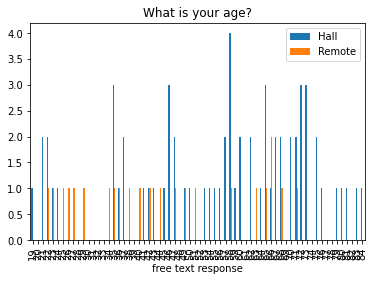

19.0
58.0
84.0
22.0
42.0
71.0


In [82]:
R_df = pd.DataFrame(index = range(19,85))
R_df['Hall'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B') ,Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar()
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])
plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].min())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].median())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].max())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B'),Quest_text.loc[q,'ID']].min())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B'),Quest_text.loc[q,'ID']].median())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B'),Quest_text.loc[q,'ID']].max())



In [83]:
q = 5
Quest_text.loc[q,:]

ID                                                                        fan
English_Q                   Are you a fan or admirer of the Danish String ...
Danish_Q                    Er du en fan eller beundrer af Den Danske Stry...
Response_Type                                                 multiple choice
Data_Type                                                             integer
Response_Options_English           1 (Neutral Listener) - 7 (Big Fan/Admirer)
Response_Options_Danish     1 (Beskriver mig ikke godt) - 5 (Beskriver mig...
Survey_Timing                                                     Pre-concert
Survey_Timing_Code                                                        1.0
Repeated_Question_Code                                                    NaN
Note                                                                      NaN
Reference                                                                 NaN
Name: 5, dtype: object

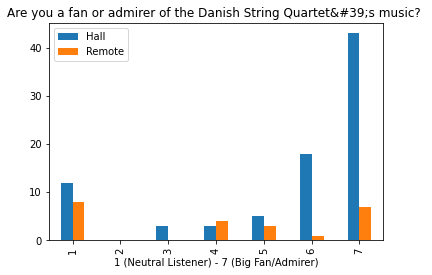

1.0
7.0
7.0
1.0
4.0
7.0


,Hall,Remote
7,0.511905,0.304348
6,0.726190,0.347826
5,0.785714,0.478261
4,0.821429,0.652174
3,0.857143,NaN
2,NaN,NaN
1,1.000000,1.000000


In [90]:
R_df = pd.DataFrame(index = range(1,8))
R_df['Hall'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B') ,Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar()
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])
plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].min())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].median())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].max())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B'),Quest_text.loc[q,'ID']].min())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B'),Quest_text.loc[q,'ID']].median())
print(Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B'),Quest_text.loc[q,'ID']].max())
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df.iloc[::-1].cumsum()

In [92]:
q = 4
Quest_text.loc[q,:]

ID                                                          personal_relation
English_Q                   What is your personal relationship to the Dani...
Danish_Q                    Hvad er din personlige relation til medlemmern...
Response_Type                                                 multiple choice
Data_Type                                                              string
Response_Options_English    "I am a relative/friend, I dont have any part...
Response_Options_Danish     "Jeg er en ven/familie, Jeg har ikke nogen bes...
Survey_Timing                                                     Pre-concert
Survey_Timing_Code                                                        1.0
Repeated_Question_Code                                                    NaN
Note                                                                      NaN
Reference                                                                 NaN
Name: 4, dtype: object

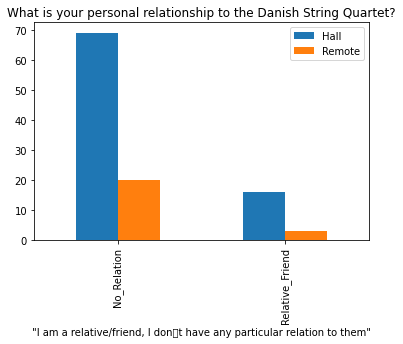

,Hall,Remote
Relative_Friend,0.188235,0.130435
No_Relation,1.000000,1.000000


In [94]:
R_df = pd.DataFrame()
R_df['Hall'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B') ,Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar()
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])
plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df.iloc[::-1].cumsum()

In [95]:
q = 3
Quest_text.loc[q,:]

ID                                                            musician_status
English_Q                                     Which title best describes you?
Danish_Q                            Hvilken beskrivelse passer bedst til dig?
Response_Type                                                 multiple choice
Data_Type                                                              string
Response_Options_English    "Tone-deaf, Nonmusician, Music-loving nonmusic...
Response_Options_Danish     "Tonedøv, Ikke-musiker, Musikelskende ikke-mus...
Survey_Timing                                                     Pre-concert
Survey_Timing_Code                                                        1.0
Repeated_Question_Code                                                    NaN
Note                        "A single item measure for identifying musicia...
Reference                                              Zhang & Schubert, 2019
Name: 3, dtype: object

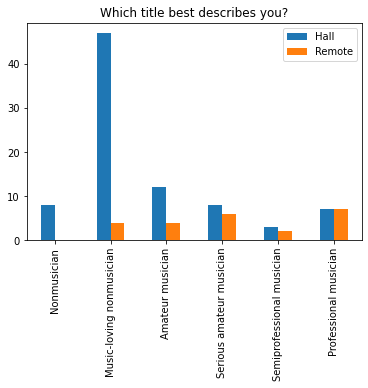

,Hall,Remote
Professional musician,0.082353,0.304348
Semiprofessional musician,0.117647,0.391304
Serious amateur musician,0.211765,0.652174
Amateur musician,0.352941,0.826087
Music-loving nonmusician,0.905882,1.000000
Nonmusician,1.000000,NaN


In [97]:
R_df = pd.DataFrame(index = ['Nonmusician','Music-loving nonmusician', 'Amateur musician', 
       'Serious amateur musician', 'Semiprofessional musician', 'Professional musician'])
R_df['Hall'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B') ,Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar()
# plt.xlabel(Quest_text.loc[q,'Response_Options_English'])
plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df.iloc[::-1].cumsum()

ID                                                         familiar_Beethoven
English_Q                    Were you familiar with the music that you heard?
Danish_Q                                         Kendte du musikken du hørte?
Response_Type                                                 multiple choice
Data_Type                                                             integer
Response_Options_English    0 (I have never heard it before) to 6 (I am ve...
Response_Options_Danish     0 (Jeg har aldrig hørt det før) - 6 (Jeg kende...
Survey_Timing                                                  Post-Beethoven
Survey_Timing_Code                                                        2.0
Repeated_Question_Code                                                   27.0
Note                                                                      NaN
Reference                                                                 NaN
Name: 39, dtype: object

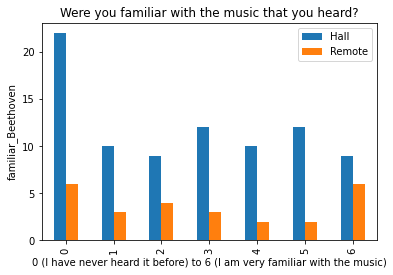

Hall      31
Remote    10
dtype: int64


,Hall,Remote
6,0.107143,0.230769
5,0.250000,0.307692
4,0.369048,0.384615
3,0.511905,0.500000
2,0.619048,0.653846
1,0.738095,0.769231
0,1.000000,1.000000


In [98]:
q = 39
Quest_text.loc[q,:]
R_df = pd.DataFrame(index = range(0,7))
R_df['Hall'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B') ,Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar()
plt.ylabel(Quest_text.loc[q,'ID'])
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])

plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
print(R_df.loc[4:,:].sum())
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df.iloc[::-1].cumsum()

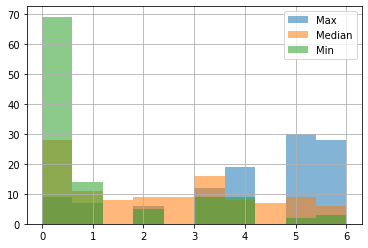

In [109]:
Quest_df.iloc[:,[39,79,100,131]].max(axis=1).hist(alpha = 0.55,label='Max') 
Quest_df.iloc[:,[39,79,100,131]].median(axis=1).hist(alpha = 0.55,label='Median')
Quest_df.iloc[:,[39,79,100,131]].min(axis=1).hist(alpha = 0.55,label='Min')
plt.legend()   
plt.show()

In [117]:
Quest_df.iloc[:,[39,79,100,131]].median(axis=1).median()


2.0

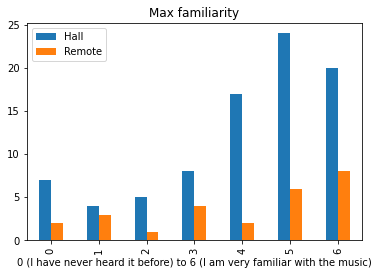

Hall      61
Remote    16
dtype: int64


,Hall,Remote
6,0.235294,0.307692
5,0.517647,0.538462
4,0.717647,0.615385
3,0.811765,0.769231
2,0.870588,0.807692
1,0.917647,0.923077
0,1.000000,1.000000


In [114]:
MQ = Quest_df.iloc[:,[39,79,100,131]].max(axis=1)
R_df['Hall'] = MQ.loc[pd.Series(aligned_Part_Codes).str.startswith('A')].value_counts()
R_df['Remote'] = MQ.loc[pd.Series(aligned_Part_Codes).str.startswith('B')].value_counts()
q = 39
R_df.plot.bar()
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])

plt.title('Max familiarity')
plt.show()
print(R_df.loc[4:,:].sum())
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df.iloc[::-1].cumsum()

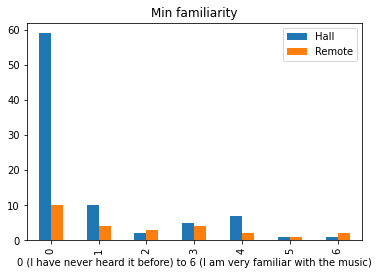

Hall      9
Remote    5
dtype: int64


,Hall,Remote
0,0.694118,0.384615
1,0.811765,0.538462
2,0.835294,0.653846
3,0.894118,0.807692
4,0.976471,0.884615
5,0.988235,0.923077
6,1.000000,1.000000


In [116]:
MQ = Quest_df.iloc[:,[39,79,100,131]].min(axis=1)
R_df['Hall'] = MQ.loc[pd.Series(aligned_Part_Codes).str.startswith('A')].value_counts()
R_df['Remote'] = MQ.loc[pd.Series(aligned_Part_Codes).str.startswith('B')].value_counts()
q = 39
R_df.plot.bar()
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])

plt.title('Min familiarity')
plt.show()
print(R_df.loc[4:,:].sum())
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df.cumsum()

array([[<AxesSubplot:title={'center':'familiar_Beethoven'}>,
        <AxesSubplot:title={'center':'familiar_Schnittke'}>],
       [<AxesSubplot:title={'center':'familiar_Bach'}>,
        <AxesSubplot:title={'center':'familiar_Folk'}>]], dtype=object)

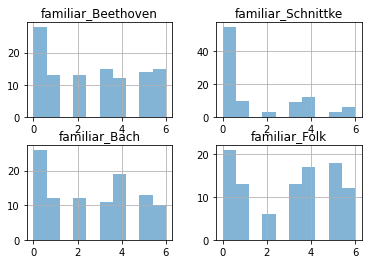

In [111]:
Quest_df.iloc[:,[39,79,100,131]].hist(alpha = 0.55) 


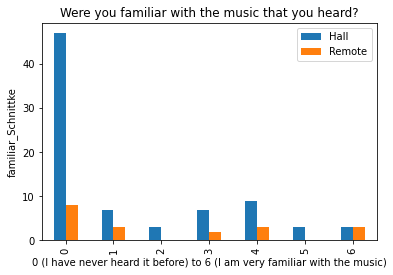

Hall      15.0
Remote     6.0
dtype: float64


,Hall,Remote
0,47,8.0
1,7,3.0
2,3,NaN
3,7,2.0
4,9,3.0
5,3,NaN
6,3,3.0


In [69]:
q = 79
Quest_text.loc[q,:]
R_df = pd.DataFrame(index = range(0,7))
R_df['Hall'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B') ,Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar()
plt.ylabel(Quest_text.loc[q,'ID'])
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])

plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
print(R_df.loc[4:,:].sum())
R_df

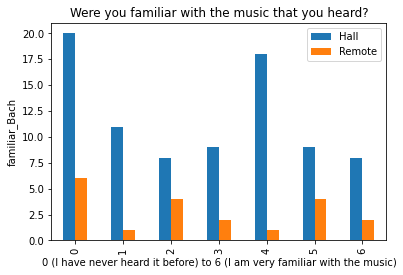

Hall      35
Remote     7
dtype: int64


,Hall,Remote
0,20,6
1,11,1
2,8,4
3,9,2
4,18,1
5,9,4
6,8,2


In [70]:
q = 100
Quest_text.loc[q,:]
R_df = pd.DataFrame(index = range(0,7))
R_df['Hall'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B') ,Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar()
plt.ylabel(Quest_text.loc[q,'ID'])
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])

plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
print(R_df.loc[4:,:].sum())
R_df

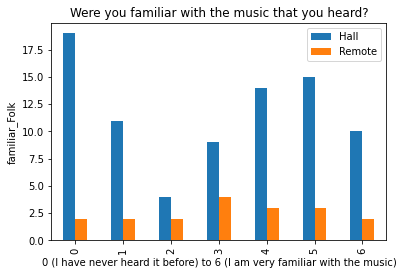

Hall      39
Remote     8
dtype: int64


,Hall,Remote
0,19,2
1,11,2
2,4,2
3,9,4
4,14,3
5,15,3
6,10,2


In [71]:
q = 131
Quest_text.loc[q,:]
R_df = pd.DataFrame(index = range(0,7))
R_df['Hall'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B') ,Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar()
plt.ylabel(Quest_text.loc[q,'ID'])
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])

plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
print(R_df.loc[4:,:].sum())
R_df

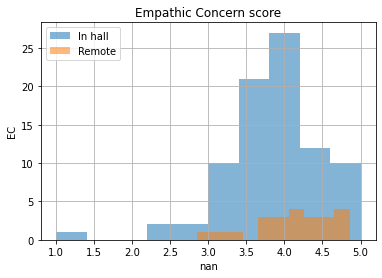

In [126]:
q = 210
Quest_text.loc[q,:]
Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].hist(alpha = 0.55,label='In hall') 
Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B'),Quest_text.loc[q,'ID']].hist(alpha = 0.55,label='Remote') 
plt.legend() 
plt.ylabel(Quest_text.loc[q,'ID'])
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])

plt.title('Empathic Concern score')
plt.show()

plt.show()

[112.67058823529412, 25.74017992837459]
[117.89473684210526, 17.336200842431506]


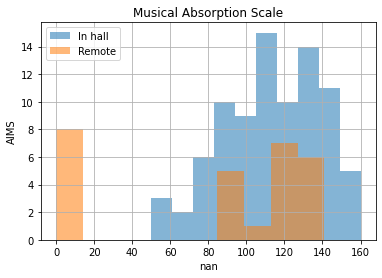

In [134]:
q = 212
Quest_text.loc[q,:]
Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].hist(alpha = 0.55,label='In hall')
print([Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].mean(),Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('A'),Quest_text.loc[q,'ID']].std()])
Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B'),Quest_text.loc[q,'ID']].hist(alpha = 0.55,label='Remote') 
temp_df = Quest_df.loc[pd.Series(aligned_Part_Codes).str.startswith('B'),Quest_text.loc[q,'ID']].copy()
temp_df = temp_df.loc[temp_df>0].copy()
print([temp_df.mean(),temp_df.std()])

plt.legend() 
plt.ylabel(Quest_text.loc[q,'ID'])
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])

plt.title('Musical Absorption Scale')
plt.show()

plt.show()

In [321]:
q = 200
Quest_text.loc[q,:]

ID                                                        viewing_with_others
English_Q                   Are you viewing the concert with anyone you know?
Danish_Q                                Ser du koncerten med nogen du kender?
Response_Type                                                            text
Data_Type                                                              string
Response_Options_English                                   free text response
Response_Options_Danish                                    free text response
Survey_Timing                                                     Pre-concert
Survey_Timing_Code                                                        1.0
Repeated_Question_Code                                                    NaN
Note                                                             Virtual_only
Reference                                                                 NaN
Name: 200, dtype: object

In [56]:
R_df.index

Index(['Music-loving nonmusician', 'Amateur musician', 'Nonmusician',
       'Serious amateur musician', 'Professional musician',
       'Semiprofessional musician'],
      dtype='object')

## Report motion responses
per section/piece, against average motion

In [135]:
list1 = Quest_df.columns.values
list2 = Quest_text['ID'].values
s1 = set(list1)
s2 = set(list2)

if s1 == s2:
    print("Both List are the same")
else:
    print("Not same")
    print(s1.difference(s2))
    print(s2.difference(s1))

Both List are the same


In [136]:
df = Quest_df
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
#unique_counts['']

In [137]:
sub_Q_List=['ParticipantCode',
            'aware_body_Beethoven', 'aware_movement_Beethoven', 'aware_others_moving_Beethoven',
            'aware_body_Schnittke', 'aware_movement_Schnittke', 'aware_others_moving_Schnittke',
            'aware_body_Bach', 'aware_movement_Bach', 'aware_others_moving_Bach', # bach
            'aware_body_Folk', 'aware_movement_Folk', 'aware_others_moving_Folk']

In [138]:
sub_text = Quest_text.loc[Quest_text['ID'].isin(sub_Q_List),:]
sub_text.set_index('ID',drop=True,inplace = True)
sub_text

,English_Q,Danish_Q,Response_Type,Data_Type,Response_Options_English,Response_Options_Danish,Survey_Timing,Survey_Timing_Code,Repeated_Question_Code,Note,Reference
ID,,,,,,,,,,,
ParticipantCode,NaN,NaN,factor,string,NaN,NaN,NaN,NaN,NaN,Participant Identifier. See the README for inf...,NaN
aware_body_Beethoven,Were you aware of your physical body during th...,Var du opmærksom på din krop gennem dette stykke?,multiple choice,string,"""Not at all, Rarely, Intermittently, Continuou...","""Overhovedet ikke, Sjældent, Fra tid til anden...",Post-Beethoven,2.0,38.0,Developed for MusicLab Copenhagen,NaN
aware_movement_Beethoven,Were you aware of your own physical movement d...,Var du opmærksom på dine egne bevægelser genne...,multiple choice,string,"""Not aware of movement, Yes and I moved less t...","""Ikke opmærksom på bevægelse, Ja og jeg bevæge...",Post-Beethoven,2.0,39.0,Developed for MusicLab Copenhagen,NaN
aware_others_moving_Beethoven,Were you aware of others in the audience movin...,Var du opmærksom på at andre i publikum bevæge...,multiple choice,string,"""Not aware of others' movement, Yes and they m...","""Ikke opmærksom på andres bevægelse, Ja og de ...",Post-Beethoven,2.0,40.0,Developed for MusicLab Copenhagen,NaN
aware_body_Schnittke,Were you aware of your physical body during th...,Var du opmærksom på din krop gennem dette stykke?,multiple choice,string,"""Not at all, Rarely, Intermittently, Continuou...","""Overhovedet ikke, Sjældent, Fra tid til anden...",Post-Schnittke,3.0,38.0,Developed for MusicLab Copenhagen,NaN
aware_movement_Schnittke,Were you aware of your own physical movement d...,Var du opmærksom på dine egne bevægelser genne...,multiple choice,string,"""Not aware of movement, Yes and I moved less t...","""Ikke opmærksom på bevægelse, Ja og jeg bevæge...",Post-Schnittke,3.0,39.0,Developed for MusicLab Copenhagen,NaN
aware_others_moving_Schnittke,Were you aware of others in the audience movin...,Var du opmærksom på at andre i publikum bevæge...,multiple choice,string,"""Not aware of others' movement, Yes and they m...","""Ikke opmærksom på andres bevægelse, Ja og de ...",Post-Schnittke,3.0,40.0,Developed for MusicLab Copenhagen,NaN
aware_body_Bach,Were you aware of your physical body during th...,Var du opmærksom på din krop gennem dette stykke?,multiple choice,integer,"""Not at all, Rarely, Intermittently, Continuou...","""Overhovedet ikke, Sjældent, Fra tid til anden...",Post-Bach,4.0,38.0,Developed for MusicLab Copenhagen,NaN
aware_movement_Bach,Were you aware of your own physical movement d...,Var du opmærksom på dine egne bevægelser genne...,multiple choice,integer,"""Not aware of movement, Yes and I moved less t...","""Ikke opmærksom på bevægelse, Ja og jeg bevæge...",Post-Bach,4.0,39.0,Developed for MusicLab Copenhagen,NaN


In [139]:
sub_Q = Quest_df[sub_Q_List].copy()
sub_Q = sub_Q.sort_values('ParticipantCode').reset_index()
sub_Q

,index,ParticipantCode,aware_body_Beethoven,aware_movement_Beethoven,aware_others_moving_Beethoven,aware_body_Schnittke,aware_movement_Schnittke,aware_others_moving_Schnittke,aware_body_Bach,aware_movement_Bach,aware_others_moving_Bach,aware_body_Folk,aware_movement_Folk,aware_others_moving_Folk
0,61,ADQ001,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved a normal amount,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Not aware of others' movement,Continuously,Yes and I moved more than usual,Yes and they moved more than usual
1,83,ADQ002,Rarely,Not aware of movement,Not aware of others' movement,Not at all,Yes and I moved less than usual,Not aware of others' movement,Intermittently,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
2,68,ADQ003,Continuously,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved a normal amount,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual
3,28,ADQ004,Not at all,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Not aware of others' movement,Not at all,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
4,55,ADQ005,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Not at all,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Yes and they moved less than usual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,109,BEQ115,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,NaN,NaN,NaN,Rarely,Not aware of movement,Not aware of others' movement,NaN,NaN,NaN
108,101,BEQ116,Continuously,Yes and I moved less than usual,Not aware of others' movement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,94,BEQ117,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,89,BEQ118,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
sub_H = sub_Q.loc[sub_Q['ParticipantCode'].str.startswith('A'),:].copy()
sub_H

,index,ParticipantCode,aware_body_Beethoven,aware_movement_Beethoven,aware_others_moving_Beethoven,aware_body_Schnittke,aware_movement_Schnittke,aware_others_moving_Schnittke,aware_body_Bach,aware_movement_Bach,aware_others_moving_Bach,aware_body_Folk,aware_movement_Folk,aware_others_moving_Folk
0,61,ADQ001,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved a normal amount,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Not aware of others' movement,Continuously,Yes and I moved more than usual,Yes and they moved more than usual
1,83,ADQ002,Rarely,Not aware of movement,Not aware of others' movement,Not at all,Yes and I moved less than usual,Not aware of others' movement,Intermittently,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
2,68,ADQ003,Continuously,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved a normal amount,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual
3,28,ADQ004,Not at all,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Not aware of others' movement,Not at all,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved more than usual,Yes and they moved more than usual
4,55,ADQ005,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,Not at all,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Yes and they moved less than usual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0,AEQ086,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Continuously,Yes and I moved less than usual,Yes and they moved a normal amount
81,11,AEQ087,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Rarely,Yes and I moved less than usual,Not aware of others' movement,Not at all,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount
82,1,AEQ088,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Rarely,Not aware of movement,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Not aware of others' movement
83,8,AEQ089,Intermittently,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount,Intermittently,Yes and I moved a normal amount,Yes and they moved a normal amount


In [141]:
sub_V = sub_Q.loc[sub_Q['ParticipantCode'].str.startswith('B'),:].copy()
sub_V

,index,ParticipantCode,aware_body_Beethoven,aware_movement_Beethoven,aware_others_moving_Beethoven,aware_body_Schnittke,aware_movement_Schnittke,aware_others_moving_Schnittke,aware_body_Bach,aware_movement_Bach,aware_others_moving_Bach,aware_body_Folk,aware_movement_Folk,aware_others_moving_Folk
85,110,BDQ092,Rarely,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved less than usual,Not aware of others' movement,NaN,NaN,NaN
86,105,BDQ093,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,108,BEQ095,Intermittently,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved more than usual,Not aware of others' movement,Intermittently,Yes and I moved less than usual,Not aware of others' movement,Continuously,Yes and I moved a normal amount,Not aware of others' movement
88,102,BEQ096,Intermittently,Yes and I moved more than usual,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Not aware of others' movement
89,95,BEQ097,Continuously,Yes and I moved less than usual,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,Intermittently,Yes and I moved a normal amount,Yes and they moved less than usual
90,88,BEQ098,Continuously,Yes and I moved a normal amount,Not aware of others' movement,Continuously,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Continuously,Yes and I moved a normal amount,Not aware of others' movement
91,85,BEQ099,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Not aware of others' movement,Rarely,Yes and I moved less than usual,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Not aware of others' movement
92,96,BEQ100,Rarely,Yes and I moved a normal amount,Not aware of others' movement,Rarely,Not aware of movement,Not aware of others' movement,Rarely,Not aware of movement,Not aware of others' movement,Rarely,Not aware of movement,Not aware of others' movement
93,90,BEQ101,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,Rarely,Yes and I moved a normal amount,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Yes and they moved more than usual
94,111,BEQ102,Intermittently,Yes and I moved less than usual,Not aware of others' movement,Rarely,Not aware of movement,Not aware of others' movement,Intermittently,Yes and I moved less than usual,Not aware of others' movement,Intermittently,Yes and I moved a normal amount,Not aware of others' movement


<AxesSubplot:>

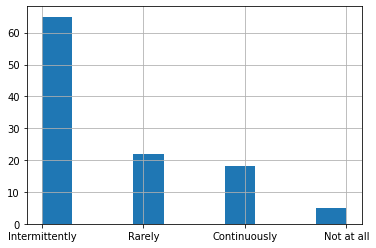

In [142]:
c = 'aware_body_Beethoven'
sub_Q[c].hist()

In [143]:
# reQ
req_Q_List=['ParticipantCode','Music','Stimuli_N','aware_body', 'aware_movement', 'aware_others_moving']
sub_list = ['ParticipantCode','aware_body', 'aware_movement', 'aware_others_moving']
Stimuli_N = {1:'Beethoven',2:'Schnittke',3:'Bach',4:'Folk'}
 
req_Q = pd.DataFrame(columns = req_Q_List)

for stim in Stimuli_N.keys():
    mtag= Stimuli_N[stim]
    A = sub_Q.loc[:,['ParticipantCode','aware_body_'+mtag, 'aware_movement_'+mtag, 'aware_others_moving_'+mtag]].copy()
    A=A.rename(columns={'aware_body_'+mtag:'aware_body', 'aware_movement_'+mtag:'aware_movement','aware_others_moving_'+mtag:'aware_others_moving'})
    A['Music'] = mtag
    A['Stimuli_N'] = stim

    req_Q = pd.concat([req_Q,A],axis=0)

req_Q

,ParticipantCode,Music,Stimuli_N,aware_body,aware_movement,aware_others_moving
0,ADQ001,Beethoven,1,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual
1,ADQ002,Beethoven,1,Rarely,Not aware of movement,Not aware of others' movement
2,ADQ003,Beethoven,1,Continuously,Yes and I moved a normal amount,Not aware of others' movement
3,ADQ004,Beethoven,1,Not at all,Yes and I moved less than usual,Not aware of others' movement
4,ADQ005,Beethoven,1,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount
...,...,...,...,...,...,...
107,BEQ115,Folk,4,NaN,NaN,NaN
108,BEQ116,Folk,4,NaN,NaN,NaN
109,BEQ117,Folk,4,NaN,NaN,NaN
110,BEQ118,Folk,4,NaN,NaN,NaN


Add the average motion per segment to the rating information per participant

In [28]:
Cond = ['Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual'] # hall for 85 and virtual for 30

#Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29]}
Event_ranges = {'Beethoven':[6,10],'Schnittke':[15,18],'Bach':[25,26]}

mm_df = pd.DataFrame(columns=['Participant','Condition','Music','mQoM'])

for ev in Event_ranges.keys():
    mdf = pd.DataFrame(columns=['Participant','Condition','Music','mQoM','aware_body', 'aware_movement', 'aware_others_moving'])
    mdf['Participant']= aud_df.columns.values
    mdf['Condition'] = Cond
    mdf['Music'] = ev
    mdf['aware_body'] = sub_Q['aware_body_'+ev]
    mdf['aware_movement'] = sub_Q['aware_movement_'+ev]
    mdf['aware_others_moving'] = sub_Q['aware_others_moving_'+ev]

    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mdf.loc[:,'mQoM'] = aud_df.loc[seg_start:seg_end,:].copy().mean(skipna=True).values
    motion_seen = []
    motion_seen_max = []
    for part in mdf['Participant']:
        neighbours = Full_Rels.loc[Full_Rels['Participant_Code_1'].isin([part]),:]
        seen_neighbours = neighbours.loc[neighbours['Distance'].isin([1.0,2.0]),'Participant_Code_2'].values
        motion_seen.append(mdf.loc[mdf['Participant'].isin(seen_neighbours),'mQoM'].mean())
        motion_seen_max.append(mdf.loc[mdf['Participant'].isin(seen_neighbours),'mQoM'].max()) # mean()
    mdf['Motion_seen'] = motion_seen
    mdf['Motion_seen_Max'] = motion_seen_max

    mm_df = pd.concat([mm_df,mdf])

# Folk
#Event_ranges = {'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
Event_ranges = {'Folk 1':[30,31],'Folk 2':[32,33],'Folk 3':[35,36],'Folk 4':[38,39],'Folk 5':[41,42],'Folk 6':[47,48]}

folk_df = pd.DataFrame(columns = Event_ranges.keys())
for ev in Event_ranges:
    print(ev)
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    folk_df.loc[:,ev] = aud_df.loc[seg_start:seg_end,:].copy().mean(skipna=True).values
    
ev = 'Folk'
print(ev)
mdf = pd.DataFrame(columns=['Participant','Condition','Music','mQoM','aware_body', 'aware_movement', 'aware_others_moving'])
mdf['Participant']= aud_df.columns.values
mdf['Condition'] = Cond
mdf['Music'] = ev
mdf['aware_body'] = sub_Q['aware_body_'+ev]
mdf['aware_movement'] = sub_Q['aware_movement_'+ev]
mdf['aware_others_moving'] = sub_Q['aware_others_moving_'+ev]

mdf.loc[:,'mQoM'] = folk_df.mean(axis=1,skipna=True).values
motion_seen = []
motion_seen_max = []
for part in mdf['Participant']:
    neighbours = Full_Rels.loc[Full_Rels['Participant_Code_1'].isin([part]),:]
    seen_neighbours = neighbours.loc[neighbours['Distance'].isin([1.0,2.0]),'Participant_Code_2'].values
    motion_seen.append(mdf.loc[mdf['Participant'].isin(seen_neighbours),'mQoM'].mean())
    motion_seen_max.append(mdf.loc[mdf['Participant'].isin(seen_neighbours),'mQoM'].max()) # mean()
mdf['Motion_seen'] = motion_seen
mdf['Motion_seen_Max'] = motion_seen_max

mm_df = pd.concat([mm_df,mdf])
# what are these stray values?? test with mm_df['aware_body'].hist()
mm_df=mm_df.replace(['0','5'], np.nan)

mm_df

Folk 1
Folk 2
Folk 3
Folk 4
Folk 5
Folk 6
Folk


,Participant,Condition,Music,mQoM,aware_body,aware_movement,aware_others_moving,Motion_seen,Motion_seen_Max
0,ADQ001,Hall,Beethoven,0.069310,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,0.127867,0.143615
1,ADQ002,Hall,Beethoven,NaN,Rarely,Not aware of movement,Not aware of others' movement,0.085446,0.093232
2,ADQ003,Hall,Beethoven,0.094418,Continuously,Yes and I moved a normal amount,Not aware of others' movement,0.104520,0.132908
3,ADQ004,Hall,Beethoven,0.101832,Not at all,Yes and I moved less than usual,Not aware of others' movement,0.101747,0.107947
4,ADQ005,Hall,Beethoven,0.073396,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,0.056471,0.056471
...,...,...,...,...,...,...,...,...,...
107,BEQ115,Virtual,Folk,0.270163,NaN,NaN,NaN,NaN,NaN
108,BEQ116,Virtual,Folk,1.029549,NaN,NaN,NaN,NaN,NaN
109,BEQ117,Virtual,Folk,NaN,NaN,NaN,NaN,NaN,NaN
110,BEQ118,Virtual,Folk,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
mm_df.to_csv('Participants_Pieces_motion_judgements.csv')

## Plot results of questionnairs and motion
Most of these analyses are only on the motion of the participants in the hall. 


In [144]:
mm_df = pd.read_csv('Participants_Pieces_motion_judgements.csv')
# adjust the mQoM values to match fernando's
mm_df['mQoM'] = mm_df['mQoM']/0.21912705279614828
mm_df['Motion_seen'] = mm_df['Motion_seen']/0.21912705279614828
mm_df['Motion_seen_Max'] = mm_df['Motion_seen_Max']/0.21912705279614828


In [145]:
mm_df

,Unnamed: 0,Participant,Condition,Music,mQoM,aware_body,aware_movement,aware_others_moving,Motion_seen,Motion_seen_Max
0,0,ADQ001,Hall,Beethoven,0.316301,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,0.583528,0.655397
1,1,ADQ002,Hall,Beethoven,NaN,Rarely,Not aware of movement,Not aware of others' movement,0.389938,0.425472
2,2,ADQ003,Hall,Beethoven,0.430884,Continuously,Yes and I moved a normal amount,Not aware of others' movement,0.476982,0.606533
3,3,ADQ004,Hall,Beethoven,0.464719,Not at all,Yes and I moved less than usual,Not aware of others' movement,0.464331,0.492624
4,4,ADQ005,Hall,Beethoven,0.334948,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,0.257711,0.257711
...,...,...,...,...,...,...,...,...,...,...
443,107,BEQ115,Virtual,Folk,1.232904,NaN,NaN,NaN,NaN,NaN
444,108,BEQ116,Virtual,Folk,4.698409,NaN,NaN,NaN,NaN,NaN
445,109,BEQ117,Virtual,Folk,NaN,NaN,NaN,NaN,NaN,NaN
446,110,BEQ118,Virtual,Folk,NaN,NaN,NaN,NaN,NaN,NaN


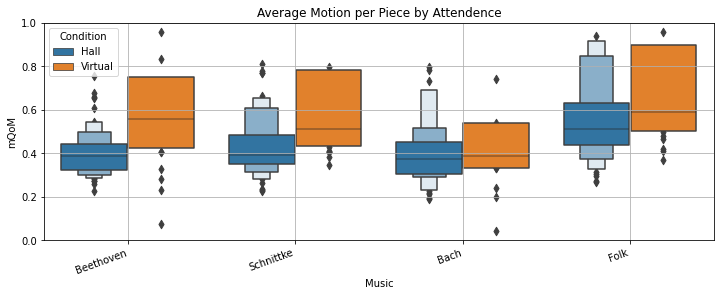

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Condition,2.332815,1,87,2.332815,18.001615,5.493853e-05,NaN,0.171441,NaN,NaN,NaN,NaN
1,Music,2.091244,3,261,0.697081,15.983839,1.434117e-09,1.829018e-07,0.155207,0.735242,False,0.479065,1.983252e-12
2,Interaction,0.407177,3,261,0.135726,3.112142,2.685868e-02,NaN,0.034536,NaN,NaN,NaN,NaN


In [146]:
tag_Q = 'Condition'
tag_m = 'mQoM'
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Hall','Virtual']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df, ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by Attendence')
plt.ylim([0,1])
plt.grid()
plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df)


In [147]:
mm_df_Hall = mm_df.loc[mm_df['Condition'].isin(['Hall']),:]
mm_df_Virt = mm_df.loc[mm_df['Condition'].isin(['Virtual']),:]
# less 
mm_df_less = mm_df_Hall.loc[mm_df_Hall['Music'].isin(['Beethoven','Schnittke','Bach']),:]
mm_df_Folk = mm_df_Hall.loc[mm_df_Hall['Music'].isin(['Folk']),:]

# less 
mm_df_less_V = mm_df_Virt.loc[mm_df_Virt['Music'].isin(['Beethoven','Schnittke','Bach']),:]
mm_df_Folk_V = mm_df_Virt.loc[mm_df_Virt['Music'].isin(['Folk']),:]

### Awareness of participants of their own bodies


In [179]:
tag_Q = 'aware_body'
tag_m = 'mQoM'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']

ID
aware_body_Beethoven    Were you aware of your physical body during th...
aware_body_Schnittke    Were you aware of your physical body during th...
aware_body_Bach         Were you aware of your physical body during th...
aware_body_Folk         Were you aware of your physical body during th...
Name: English_Q, dtype: object

In [180]:
print(QuT)


Were you aware of your physical body during this piece?


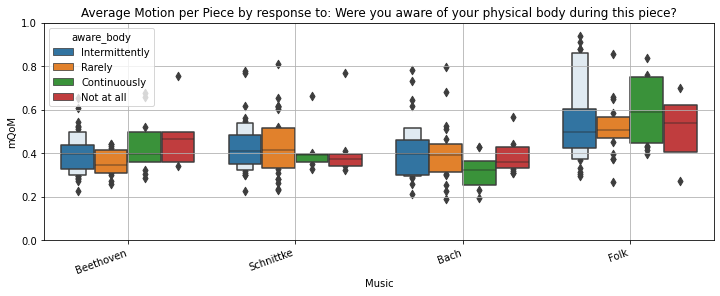

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_body,0.029014,2,19,0.014507,0.475852,6.285639e-01,NaN,0.047700,NaN,NaN,NaN,NaN
1,Music,0.387863,3,57,0.129288,17.090753,4.896319e-08,0.000074,0.473549,0.522018,False,0.211942,0.000012
2,Interaction,0.108386,6,57,0.018064,2.387961,3.972554e-02,NaN,0.200872,NaN,NaN,NaN,NaN


In [181]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Continuously','Intermittently','Rarely','Not at all']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,1])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Hall)


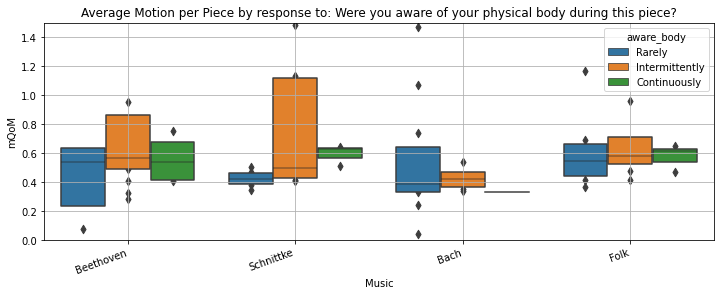

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:1534: RuntimeWarning: divide by zero encountered in scalar divide
  ms_resbetw = ss_resbetw / df_resbetw
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:1535: RuntimeWarning: divide by zero encountered in scalar divide
  ms_reswith = ss_reswith / df_reswith


,Source,SS,DF1,DF2,MS,F,np2,eps
0,aware_body,0.003155,1,0,0.003155,0.0,1.0,NaN
1,Music,0.044616,3,0,0.014872,-0.0,1.0,0.333333
2,Interaction,0.010017,3,0,0.003339,-0.0,1.0,NaN


In [182]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Continuously','Intermittently','Rarely','Not at all']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df_Virt, ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,1.5])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Virt)


In [183]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df.mean()/85

Continuously      0.132353
Intermittently    0.488235
Rarely            0.270588
Not at all        0.097059
dtype: float64

In [184]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_V[tag_Q + '_' + t].value_counts()
sub_hist_df.mean()/27

Continuously      0.101852
Intermittently    0.398148
Rarely            0.268519
Not at all             NaN
dtype: float64

       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      2  49.682735  2.222107  0.119042  0.058983


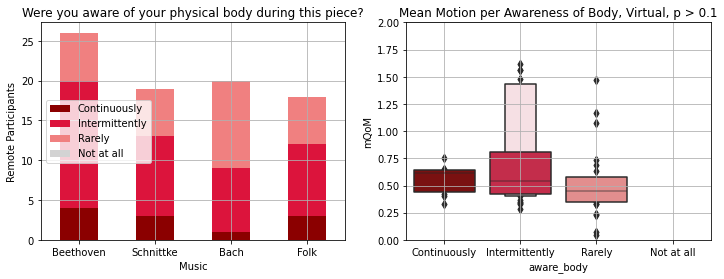

In [185]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_V[tag_Q + '_' + t].value_counts()

f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Remote Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Virt)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Virt, ax = ax2)
ax2.set_title('Mean Motion per Awareness of Body, Virtual, p > 0.1')
ax2.set_ylim([0,2])
ax2.grid()


plt.savefig('./Plots/body_aware_B_R_qom.png',bbox_inches = 'tight',dpi = 300)
plt.show()

In [186]:
# https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      2  49.682735  2.222107  0.119042  0.058983
                A               B   mean(A)   mean(B)      diff        se  \
0    Continuously  Intermittently  0.551170  0.739562 -0.188392  0.089400   
1    Continuously          Rarely  0.551170  0.565695 -0.014525  0.090172   
2  Intermittently          Rarely  0.739562  0.565695  0.173867  0.114037   

          T         df      pval    hedges  
0 -2.107296  50.999699  0.098374 -0.395206  
1 -0.161086  35.879448  0.985802 -0.038178  
2  1.524649  64.825739  0.286196  0.353963  


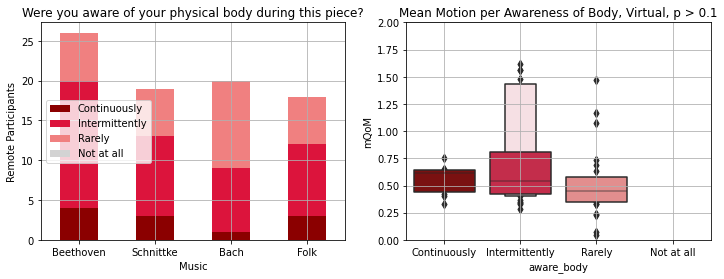

In [187]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_V[tag_Q + '_' + t].value_counts()

f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Remote Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Virt)
print(aov)
print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Virt))

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Virt, ax = ax2)
ax2.set_title('Mean Motion per Awareness of Body, Virtual, p > 0.1')
ax2.set_ylim([0,2])
ax2.grid()
# barplot_annotate_brackets(0, 3, 'p < .005',[0,1,2,3], [1,2,2.7,2.7], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
# barplot_annotate_brackets(1, 3, 'p < .05',[0,1,2,3], [1.5,2,2.3,2.3], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)


plt.savefig('./Plots/body_aware_B_R_qom.png',bbox_inches = 'tight',dpi = 300)
plt.show()

In [188]:
tag_m

'mQoM'

Were you aware of your physical body during this piece?
       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      3  84.545142  0.304361  0.822162  0.003408
                A               B   mean(A)   mean(B)      diff        se  \
0    Continuously  Intermittently  0.479686  0.447898  0.031788  0.034614   
1    Continuously      Not at all  0.479686  0.462475  0.017211  0.050750   
2    Continuously          Rarely  0.479686  0.449201  0.030485  0.040072   
3  Intermittently      Not at all  0.447898  0.462475 -0.014577  0.041258   
4  Intermittently          Rarely  0.447898  0.449201 -0.001303  0.027064   
5      Not at all          Rarely  0.462475  0.449201  0.013273  0.045933   

          T          df      pval    hedges  
0  0.918354   53.196997  0.795163  0.185367  
1  0.339138   61.093555  0.986443  0.081126  
2  0.760745   83.635307  0.871798  0.142294  
3 -0.353308   35.367850  0.984622 -0.085280  
4 -0.048164  128.388299  0.999960 -0.007162  
5  0

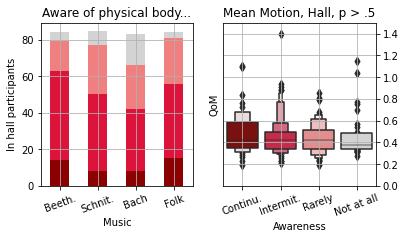

In [189]:
print(QuT)
QuT = 'Aware of physical body...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Continuously','Intermittently','Rarely','Not at all']
short_responses = ['Continu.','Intermit.','Rarely','Not at all']
resp_map = {'Continuously':'Continu.','Intermittently':'Intermit.','Rarely':'Rarely','Not at all':'Not at all'}

my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df.rename(columns=resp_map,inplace=True)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend=False,color = my_pal.values(),ax = ax1)
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticklabels(tracks_tag,rotation='20')
ax1.set_title(QuT)
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')
# fig.legend(loc='center right',ncol=3,fontsize = 8)

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)
print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall))


sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ax2.set_xticklabels(short_responses,rotation='20')
ax2.set_xlabel('Awareness')
ax2.set_ylabel('QoM')
ax2.set_title('Mean Motion, Hall, p > .5')
ax2.yaxis.tick_right()
ax2.set_ylim([0,1.5])
ax2.grid()

plt.savefig('./Plots/body_aware_A_R_qom.png',bbox_inches = 'tight',dpi = 300)
#fig.legend(labels = feats, loc='center right', ncol=3,fontsize = 8)

plt.show()


In [190]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = tracks, columns = sub_H[tag_Q + '_' + tracks[0]].unique())
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df

,Intermittently,Rarely,Continuously,Not at all,NaN
Beethoven,49.0,16.0,14.0,5.0,NaN
Schnittke,42.0,27.0,8.0,8.0,NaN
Bach,34.0,24.0,8.0,17.0,NaN
Folk,41.0,25.0,15.0,3.0,NaN


In [191]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Continuously,Intermittently,0.479686,0.447898,0.031788,0.034614,0.918354,53.196997,0.795163,0.185367
1,Continuously,Not at all,0.479686,0.462475,0.017211,0.050750,0.339138,61.093555,0.986443,0.081126
2,Continuously,Rarely,0.479686,0.449201,0.030485,0.040072,0.760745,83.635307,0.871798,0.142294
3,Intermittently,Not at all,0.447898,0.462475,-0.014577,0.041258,-0.353308,35.367850,0.984622,-0.085280
4,Intermittently,Rarely,0.447898,0.449201,-0.001303,0.027064,-0.048164,128.388299,0.999960,-0.007162
5,Not at all,Rarely,0.462475,0.449201,0.013273,0.045933,0.288971,51.899092,0.991494,0.061069


       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      3  65.026352  0.615058  0.607705  0.016351
       Source  ddof1     ddof2         F     p-unc       np2
0  aware_body      3  9.243396  0.497837  0.692644  0.017931


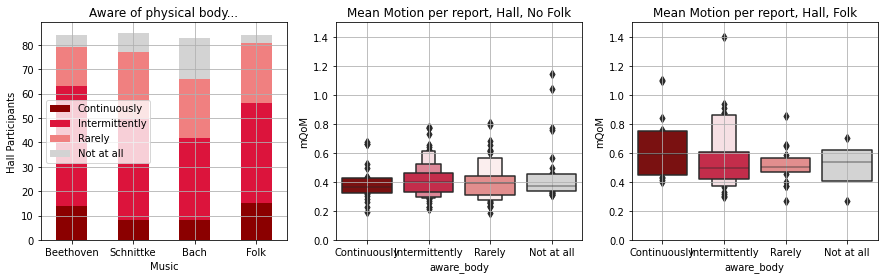

In [192]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
ax2.set_title('Mean Motion per report, Hall, No Folk')
ax2.set_ylim([0,1.5])
ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
ax3.set_title('Mean Motion per report, Hall, Folk')
ax3.set_ylim([0,1.5])
ax3.grid()
plt.savefig('./Plots/body_aware_A_R_qom_less.png',bbox_inches = 'tight',dpi = 300)
plt.show()

### Amount of motion (normative)


In [273]:
tag_Q = 'aware_movement'
tag_m = 'mQoM'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']

ID
aware_movement_Beethoven    Were you aware of your own physical movement d...
aware_movement_Schnittke    Were you aware of your own physical movement d...
aware_movement_Bach         Were you aware of your own physical movement d...
aware_movement_Folk         Were you aware of your own physical movement d...
Name: English_Q, dtype: object

In [274]:
print(QuT)
QuT = 'Relative to your own usual behaviour...' 


Were you aware of your own physical movement during this piece? If so, how much did you move relative to your own usual behaviour at this kind of concert?


In [275]:
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Hall)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_movement,0.296770,3,8,0.098923,1.427666,0.304721,NaN,0.348693,NaN,NaN,NaN,NaN
1,Music,0.232065,3,24,0.077355,12.716482,0.000036,0.008292,0.613834,0.430282,False,0.088334,0.000284
2,Interaction,0.160893,9,24,0.017877,2.938827,0.016814,NaN,0.524276,NaN,NaN,NaN,NaN


In [276]:
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Virt)


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:1004: RuntimeWarning: invalid value encountered in scalar divide
  msbetween = ssbetween / ddof1
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:1536: RuntimeWarning: divide by zero encountered in scalar divide
  ms_inter = ss_inter / df_inter


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,aware_movement,0.000000e+00,0,1,NaN,NaN,NaN,0.000000e+00,NaN
1,Music,4.307238e-02,3,3,0.014357,1.407416,0.392779,5.846168e-01,0.333333
2,Interaction,1.387779e-17,0,3,inf,inf,NaN,4.534649e-16,NaN


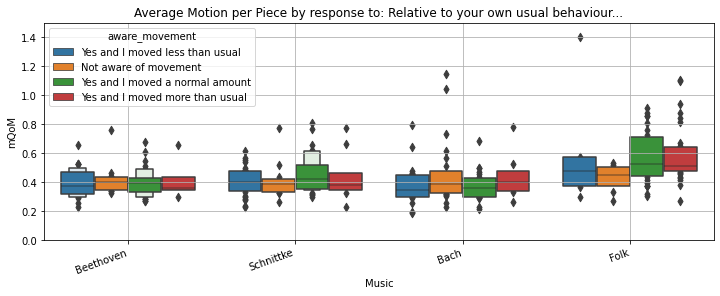

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_movement,0.296770,3,8,0.098923,1.427666,0.304721,NaN,0.348693,NaN,NaN,NaN,NaN
1,Music,0.232065,3,24,0.077355,12.716482,0.000036,0.008292,0.613834,0.430282,False,0.088334,0.000284
2,Interaction,0.160893,9,24,0.017877,2.938827,0.016814,NaN,0.524276,NaN,NaN,NaN,NaN


In [277]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}


f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,1.5])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Hall)


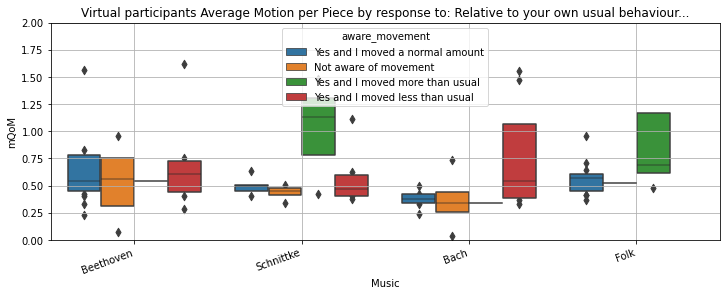

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:1004: RuntimeWarning: invalid value encountered in scalar divide
  msbetween = ssbetween / ddof1
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:1536: RuntimeWarning: divide by zero encountered in scalar divide
  ms_inter = ss_inter / df_inter


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,aware_movement,0.000000e+00,0,1,NaN,NaN,NaN,0.000000e+00,NaN
1,Music,4.307238e-02,3,3,0.014357,1.407416,0.392779,5.846168e-01,0.333333
2,Interaction,1.387779e-17,0,3,inf,inf,NaN,4.534649e-16,NaN


In [278]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}


f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df_Virt, ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Virtual participants Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,2])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Virt)


In [318]:
hall_trimed = mm_df_Hall.loc[mm_df_Hall['mQoM'].notna(),:].copy()
X = hall_trimed.loc[:,'mQoM']
Y = trimed.loc[:,'mQoM']
print([X.mean(),X.std()])
print([Y.mean(),Y.std()])
#https://vulstats.ucsd.edu/t-tests.html#summary-of-tests-for-the-mean-and-effect-sizes
df = (((s2x/len(X))+(s2y/len(Y)))**2)/(((s2x**2)/((len(X)**2)*(len(X)-1)))+((s2y**2)/((len(Y)**2)*(len(Y)-1))))
print('degrees of freedom: ' + str(df))
sp.stats.ttest_ind(X,Y, equal_var=False)

[0.45286089491024223, 0.187084171127375]
[0.7218591596135339, 0.6200390472807702]
degrees of freedom: 94.76239136527178


Ttest_indResult(statistic=-4.0853704037032035, pvalue=9.204575644544872e-05)

In [320]:
X.mean()-Y.mean()

-0.26899826470329163

In [319]:
# https://pingouin-stats.org/build/html/generated/pingouin.ttest.html#pingouin.ttest
# pinguin compensates for unequal variance and sample size with a swith to Welch-Stratheioas equation
pg.ttest(X,Y)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.08537,94.762391,two-sided,0.000092,"[-0.4, -0.14]",0.801444,332.562,0.999999


In [317]:
X = hall_trimed.loc[hall_trimed['Music']=='Folk','mQoM']
Y = trimed.loc[trimed['Music']=='Folk','mQoM']
print([X.mean(),X.std()])
print([Y.mean(),Y.std()])
#https://vulstats.ucsd.edu/t-tests.html#summary-of-tests-for-the-mean-and-effect-sizes
df = (((s2x/len(X))+(s2y/len(Y)))**2)/(((s2x**2)/((len(X)**2)*(len(X)-1)))+((s2y**2)/((len(Y)**2)*(len(Y)-1))))
print('degrees of freedom: ' + str(df)) 
sp.stats.ttest_ind(X,Y, equal_var=False)

[0.5777358273972231, 0.2576046106392593]
[0.9089954119546838, 0.9405144250294798]
degrees of freedom: 22.08835781777273


Ttest_indResult(statistic=-1.6348110011659727, pvalue=0.11638545919357683)

In [279]:
pg.rm_anova(dv='mQoM',within = 'Music',subject='Participant',data=mm_df_Virt)


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,Music,3,51,1.453531,0.238213,0.248477,0.046355,0.634807,False,0.376936,0.009144


In [272]:
trimed = mm_df_Virt.loc[mm_df_Virt['mQoM'].notna(),:].copy()
parts = trimed['Participant'].unique()
keep_parts = []
balanced_df = pd.DataFrame(columns = trimed.columns)
for p in parts:
#     print(p + ' ' + str(len(trimed.loc[trimed['Participant']==p,:])))
    if len(trimed.loc[trimed['Participant']==p,:])>3:
        keep_parts.append(p)
        balanced_df = pd.concat([balanced_df,trimed.loc[trimed['Participant']==p,:]],axis=0)

In [266]:
balanced_df

,Unnamed: 0,Participant,Condition,Music,mQoM,aware_body,aware_movement,aware_others_moving,Motion_seen,Motion_seen_Max
85,85,BDQ092,Virtual,Beethoven,2.098696,Rarely,Yes and I moved a normal amount,Not aware of others' movement,NaN,NaN
197,85,BDQ092,Virtual,Schnittke,1.116703,Intermittently,Yes and I moved less than usual,Not aware of others' movement,NaN,NaN
309,85,BDQ092,Virtual,Bach,1.468268,Rarely,Yes and I moved less than usual,Not aware of others' movement,NaN,NaN
421,85,BDQ092,Virtual,Folk,0.495229,NaN,NaN,NaN,NaN,NaN
87,87,BEQ095,Virtual,Beethoven,0.556835,Intermittently,Not aware of movement,Not aware of others' movement,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
439,103,BEQ111,Virtual,Folk,1.060422,NaN,NaN,NaN,NaN,NaN
107,107,BEQ115,Virtual,Beethoven,0.486670,Intermittently,Yes and I moved a normal amount,Not aware of others' movement,NaN,NaN
219,107,BEQ115,Virtual,Schnittke,0.730575,NaN,NaN,NaN,NaN,NaN
331,107,BEQ115,Virtual,Bach,0.738962,Rarely,Not aware of movement,Not aware of others' movement,NaN,NaN


           Source  ddof1       ddof2         F     p-unc       np2
0  aware_movement      3  135.377537  5.050367  0.002392  0.046914


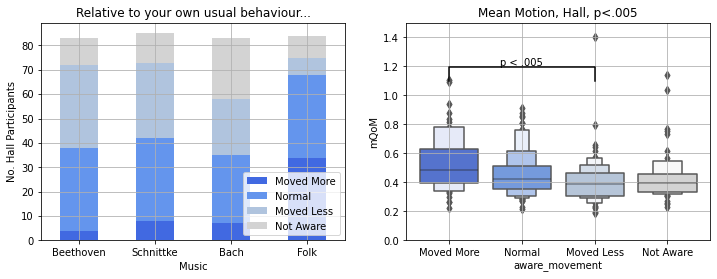

In [199]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall) 
print(aov)
sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ax2.set_xticklabels(short_responses)

ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)


ax2.set_title('Mean Motion, Hall, p<.005')
ax2.set_ylim([0,1.5])
ax2.grid()
plt.savefig('./Plots/body_move_A_R_qom.png',bbox_inches = 'tight',dpi = 300)
plt.show()


In [200]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = tracks, columns = sub_H[tag_Q + '_' + tracks[0]].unique())
for t in tracks:
    sub_hist_df.loc[t] = sub_V[tag_Q + '_' + t].value_counts()/len(sub_H)
sub_hist_df

,Yes and I moved less than usual,Not aware of movement,Yes and I moved a normal amount,Yes and I moved more than usual,NaN
Beethoven,0.082353,0.035294,0.176471,0.011765,NaN
Schnittke,0.070588,0.047059,0.070588,0.035294,NaN
Bach,0.105882,0.047059,0.070588,0.011765,NaN
Folk,NaN,0.011765,0.141176,0.058824,NaN


In [201]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = tracks, columns = sub_H[tag_Q + '_' + tracks[0]].unique())
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()/len(sub_H)
sub_hist_df

,Yes and I moved less than usual,Not aware of movement,Yes and I moved a normal amount,Yes and I moved more than usual,NaN
Beethoven,0.4,0.129412,0.4,0.047059,NaN
Schnittke,0.364706,0.141176,0.4,0.094118,NaN
Bach,0.270588,0.294118,0.329412,0.082353,NaN
Folk,0.082353,0.105882,0.4,0.4,NaN


In [202]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of movement,Yes and I moved a normal amount,0.437276,0.461843,-0.024567,0.030173,-0.814202,112.114200,0.847648,-0.126937
1,Not aware of movement,Yes and I moved less than usual,0.437276,0.407892,0.029384,0.029200,1.006311,98.947862,0.746097,0.180082
2,Not aware of movement,Yes and I moved more than usual,0.437276,0.532202,-0.094926,0.037424,-2.536474,97.101645,0.060599,-0.498422
3,Yes and I moved a normal amount,Yes and I moved less than usual,0.461843,0.407892,0.053951,0.024523,2.200036,204.999346,0.126658,0.295450
4,Yes and I moved a normal amount,Yes and I moved more than usual,0.461843,0.532202,-0.070359,0.033902,-2.075365,90.359110,0.169034,-0.349352
5,Yes and I moved less than usual,Yes and I moved more than usual,0.407892,0.532202,-0.124310,0.033038,-3.762611,81.756413,0.001761,-0.714432


In [203]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Folk)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of movement,Yes and I moved a normal amount,0.430431,0.604276,-0.173845,0.062668,-2.774050,37.761543,0.040825,-0.623952
1,Not aware of movement,Yes and I moved less than usual,0.430431,0.598566,-0.168135,0.169253,-0.993396,5.346478,0.759542,-0.601602
2,Not aware of movement,Yes and I moved more than usual,0.430431,0.592868,-0.162437,0.047488,-3.420590,29.879686,0.009369,-0.867919
3,Yes and I moved a normal amount,Yes and I moved less than usual,0.604276,0.598566,0.005710,0.175117,0.032604,6.119555,0.999986,0.017428
4,Yes and I moved a normal amount,Yes and I moved more than usual,0.604276,0.592868,0.011408,0.065379,0.174496,52.035745,0.998087,0.043766
5,Yes and I moved less than usual,Yes and I moved more than usual,0.598566,0.592868,0.005699,0.170275,0.033468,5.478846,0.999985,0.023091


In [204]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Virt)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of movement,Yes and I moved a normal amount,0.443182,0.634312,-0.191130,0.105765,-1.807120,35.678349,0.286838,-0.435871
1,Not aware of movement,Yes and I moved less than usual,0.443182,0.688124,-0.244942,0.117124,-2.091309,30.849252,0.178414,-0.647109
2,Not aware of movement,Yes and I moved more than usual,0.443182,0.909127,-0.465945,0.201352,-2.314081,11.709237,0.150433,-1.018680
3,Yes and I moved a normal amount,Yes and I moved less than usual,0.634312,0.688124,-0.053811,0.119379,-0.450761,45.651740,0.969148,-0.116888
4,Yes and I moved a normal amount,Yes and I moved more than usual,0.634312,0.909127,-0.274815,0.202672,-1.355958,12.162385,0.547484,-0.542787
5,Yes and I moved less than usual,Yes and I moved more than usual,0.688124,0.909127,-0.221004,0.208825,-1.058322,13.456310,0.719380,-0.448002


In [205]:
import matplotlib.gridspec as gridspec
#https://scientificallysound.org/2016/06/09/matplotlib-how-to-plot-subplots-of-unequal-sizes/

Own relative movement...
           Source  ddof1      ddof2         F    p-unc       np2
0  aware_movement      3  64.173667  1.014569  0.39214  0.015771
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.438676   
1            Not aware of movement  Yes and I moved less than usual  0.438676   
2            Not aware of movement  Yes and I moved more than usual  0.438676   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.412783   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.412783   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.393768   

    mean(B)      diff        se         T          df      pval    hedges  
0  0.412783  0.025893  0.030922  0.837359   59.058946  0.836453  0.179797  
1  0.393768  0.044908  0.030967  1.450195   59.255652  0.473754  0.313076  
2  0.433220  0.005456  0.047603  0.114607   38.57

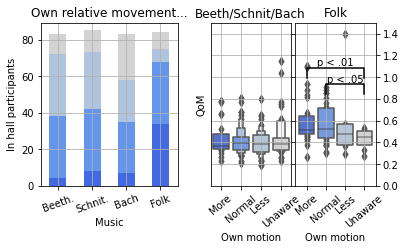

In [217]:
print(QuT)
QuT = 'Own relative movement...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['More','Normal','Less','Unaware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

fig = plt.figure(figsize=(6,3))
gridspec.GridSpec(1,4)

# large subplot
ax1 = plt.subplot2grid((1,12), (0,0), colspan=5, rowspan=1)

#f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1,legend=False)
#ax1.legend(loc="best")
ax1.grid()
#ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticklabels(tracks_tag,rotation='20')
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)
ax2 = plt.subplot2grid((1,12), (0,6), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
#ax2.set_title('Mean QoM, Hall, p>.3')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_less)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)


ax2.set_ylim([0,1.5])
ax2.yaxis.tick_right()
ax2.set_yticklabels([])
ax2.set_ylabel('QoM')

ax2.set_xlabel('Own motion')
ax2.set_xticklabels(short_responses,rotation='40')
ax2.set_title('Beeth/Schnit/Bach')
ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)
ax3 = plt.subplot2grid((1,12), (0,9), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
#ax3.set_title('Mean QoM, Hall, p<.05')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
k = 0
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3],(0.9-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.01,:]
ac = ac.loc[ac.pval>=0.01,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .01',[0,1,2,3],(0.9-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3],(0.9-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1

ax3.set_xticklabels(short_responses,rotation='40')
ax3.set_ylim([0,1.5])
ax3.set_ylabel('')
ax3.set_xlabel('Own motion')
ax3.yaxis.tick_right()
ax3.set_title('Folk')
ax3.grid()
plt.savefig('./Plots/body_move_A_R_qom_less.png',bbox_inches = 'tight',dpi = 300)

plt.show()



           Source  ddof1      ddof2         F     p-unc       np2
0  aware_movement      3  28.402548  2.680861  0.065735  0.092713
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.443182   
1            Not aware of movement  Yes and I moved less than usual  0.443182   
2            Not aware of movement  Yes and I moved more than usual  0.443182   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.634312   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.634312   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.688124   

    mean(B)      diff        se         T         df      pval    hedges  
0  0.634312 -0.191130  0.105765 -1.807120  35.678349  0.286838 -0.435871  
1  0.688124 -0.244942  0.117124 -2.091309  30.849252  0.178414 -0.647109  
2  0.909127 -0.465945  0.201352 -2.314081  11.709237  0.150433 -1.018680  


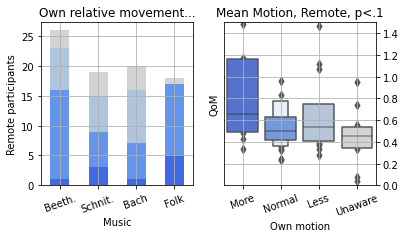

In [218]:
# tracks = ['Beethoven','Schnittke','Bach','Folk']
# response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
# short_responses = ['Moved More','Normal','Moved Less','Not Aware']
# my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_V[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend = False, color = my_pal.values(),ax = ax1)
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
ax1.set_ylabel('Remote participants')
ax1.set_xlabel('Music')
ax1.set_xticklabels(tracks_tag,rotation='20')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Virt) 
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Virt, ax = ax2)
ax2.set_xticklabels(short_responses)
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Virt)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
k = 0
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3],(0.75-0.07*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.01,:]
ac = ac.loc[ac.pval>=0.01,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .01',[0,1,2,3],(0.75-0.07*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3],(0.75-0.07*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1

ax2.set_xticklabels(short_responses,rotation='20')
ax2.yaxis.tick_right()
ax2.set_xlabel('Own motion')
ax2.set_ylabel('QoM')
ax2.set_title('Mean Motion, Remote, p<.1')
ax2.set_ylim([0,1.5])
ax2.grid()
plt.savefig('./Plots/body_move_B_R_qom.png',bbox_inches = 'tight',dpi = 300)
plt.show()


           Source  ddof1      ddof2        F     p-unc       np2
0  aware_movement      3  16.319971  1.88219  0.172502  0.047466
           Source  ddof1      ddof2         F     p-unc       np2
0  aware_movement      2  11.114391  0.990801  0.401823  0.413381


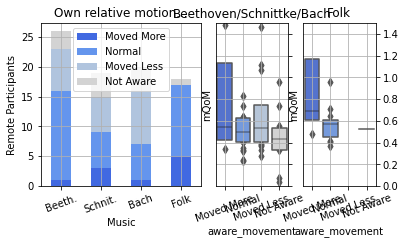

In [323]:

tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_V[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

fig = plt.figure(figsize=(6,3))
#gridspec.GridSpec(1,4)

# large subplot
ax1 = plt.subplot2grid((1,4), (0,0), colspan=2, rowspan=1)

#f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid()
ax1.set_xticklabels(tracks_tag,rotation='20')
#ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Remote Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less_V)
print(aov)
ax2 = plt.subplot2grid((1,4), (0,2), colspan=1, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_less_V, ax = ax2)
#ax2.set_title('Mean QoM, Hall, p>.3')
ax2.set_ylim([0,1.5])
ax2.yaxis.tick_right()
ax2.set_yticklabels([])
ax2.set_xticklabels(short_responses,rotation='20')
ax2.set_title('Beethoven/Schnittke/Bach')
ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk_V)
print(aov)
ax3 = plt.subplot2grid((1,4), (0,3), colspan=1, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Folk_V, ax = ax3)
#ax3.set_title('Mean QoM, Hall, p<.05')
ax3.set_xticklabels(short_responses,rotation='20')
ax3.set_ylim([0,1.5])
ax3.yaxis.tick_right()
ax3.set_title('Folk')
ax3.grid()
plt.savefig('./Plots/body_move_B_R_qom_less.png',bbox_inches = 'tight',dpi = 300)

plt.show()



           Source  ddof1      ddof2         F    p-unc       np2
0  aware_movement      3  64.173667  1.014569  0.39214  0.015771
           Source  ddof1     ddof2         F     p-unc       np2
0  aware_movement      3  18.84458  4.694926  0.012989  0.044463
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.430431   
1            Not aware of movement  Yes and I moved less than usual  0.430431   
2            Not aware of movement  Yes and I moved more than usual  0.430431   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.604276   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.604276   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.598566   

    mean(B)      diff        se         T         df      pval    hedges  
0  0.604276 -0.173845  0.062668 -2.774050  37.761543  0.040825 -0.623952  
1  0.598566 -0.168135 

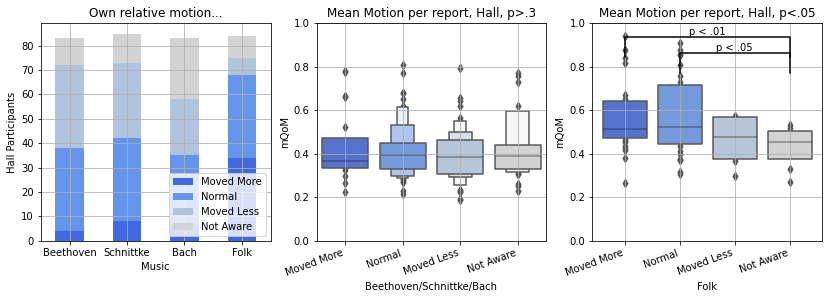

In [324]:

tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
ax2.set_title('Mean Motion per report, Hall, p>.3')
ax2.set_ylim([0,1.0])
ax2.set_xticklabels(short_responses,rotation='20',ha = 'right')
ax2.set_xlabel('Beethoven/Schnittke/Bach')
ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
k = 0
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3],(0.75-0.07*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.01,:]
ac = ac.loc[ac.pval>=0.01,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .01',[0,1,2,3],(0.75-0.07*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3],(0.75-0.07*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1


ax3.set_title('Mean Motion per report, Hall, p<.05')
ax3.set_xticklabels(short_responses,rotation='20',ha = 'right')
ax3.set_ylim([0,1.0])
ax3.set_xlabel('Folk')
ax3.grid()
plt.savefig('./Plots/body_move_A_R_qom_less_3.png',bbox_inches = 'tight',dpi = 300)

plt.show()



In [325]:
60*(1.4)

84.0

In [326]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Folk)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of movement,Yes and I moved a normal amount,0.430431,0.604276,-0.173845,0.062668,-2.774050,37.761543,0.040825,-0.623952
1,Not aware of movement,Yes and I moved less than usual,0.430431,0.598566,-0.168135,0.169253,-0.993396,5.346478,0.759542,-0.601602
2,Not aware of movement,Yes and I moved more than usual,0.430431,0.592868,-0.162437,0.047488,-3.420590,29.879686,0.009369,-0.867919
3,Yes and I moved a normal amount,Yes and I moved less than usual,0.604276,0.598566,0.005710,0.175117,0.032604,6.119555,0.999986,0.017428
4,Yes and I moved a normal amount,Yes and I moved more than usual,0.604276,0.592868,0.011408,0.065379,0.174496,52.035745,0.998087,0.043766
5,Yes and I moved less than usual,Yes and I moved more than usual,0.598566,0.592868,0.005699,0.170275,0.033468,5.478846,0.999985,0.023091


In [327]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_less)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of movement,Yes and I moved a normal amount,0.438676,0.412783,0.025893,0.030922,0.837359,59.058946,0.836453,0.179797
1,Not aware of movement,Yes and I moved less than usual,0.438676,0.393768,0.044908,0.030967,1.450195,59.255652,0.473754,0.313076
2,Not aware of movement,Yes and I moved more than usual,0.438676,0.433220,0.005456,0.047603,0.114607,38.579512,0.999452,0.029539
3,Yes and I moved a normal amount,Yes and I moved less than usual,0.412783,0.393768,0.019015,0.017208,1.104976,168.339957,0.686975,0.168095
4,Yes and I moved a normal amount,Yes and I moved more than usual,0.412783,0.433220,-0.020438,0.040040,-0.510424,21.763535,0.955724,-0.162291
5,Yes and I moved less than usual,Yes and I moved more than usual,0.393768,0.433220,-0.039452,0.040075,-0.984472,21.831250,0.759636,-0.320039


### Amount of motion (normative) for OTHERS


In [219]:
tag_Q = 'aware_others_moving'
tag_m = 'Motion_seen'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']

ID
aware_others_moving_Beethoven    Were you aware of others in the audience movin...
aware_others_moving_Schnittke    Were you aware of others in the audience movin...
aware_others_moving_Bach         Were you aware of others in the audience movin...
aware_others_moving_Folk         Were you aware of others in the audience movin...
Name: English_Q, dtype: object

In [220]:
print(QuT)
QuT = 'How were others moving...' 

Were you aware of others in the audience moving during the piece? If so, how much were they moving relative to the usual behaviour you observe at this kind of concert?


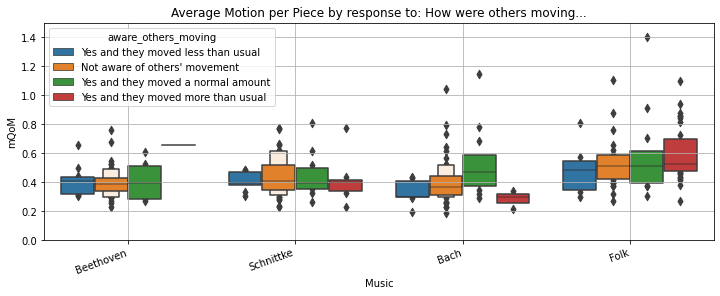

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_others_moving,0.130247,2,21,0.065123,0.495466,0.616233,NaN,0.045061,NaN,NaN,NaN,NaN
1,Music,0.721165,3,63,0.240388,8.111834,0.000119,0.006677,0.278644,0.409077,False,0.049691,1.144560e-12
2,Interaction,0.289979,6,63,0.048330,1.630876,0.153400,NaN,0.134440,NaN,NaN,NaN,NaN


In [221]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
sns.boxenplot(x = 'Music',y = 'mQoM', hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,1.5])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv='mQoM',within = 'Music',between = tag_Q,subject='Participant',data=mm_df_Hall)


In [222]:
sub_H[tag_Q + '_' + t].value_counts()


Yes and they moved more than usual    34
Not aware of others' movement         27
Yes and they moved a normal amount    15
Yes and they moved less than usual     7
Name: aware_others_moving_Folk, dtype: int64

                Source  ddof1      ddof2         F     p-unc       np2
0  aware_others_moving      3  87.663219  11.98378  0.000001  0.166302
                                    A                                   B  \
0       Not aware of others' movement  Yes and they moved a normal amount   
1       Not aware of others' movement  Yes and they moved less than usual   
2       Not aware of others' movement  Yes and they moved more than usual   
3  Yes and they moved a normal amount  Yes and they moved less than usual   
4  Yes and they moved a normal amount  Yes and they moved more than usual   
5  Yes and they moved less than usual  Yes and they moved more than usual   

    mean(A)   mean(B)      diff        se         T         df      pval  \
0  0.409257  0.447574 -0.038317  0.019051 -2.011288  58.127771  0.195687   
1  0.409257  0.409986 -0.000729  0.015037 -0.048465  57.423472  0.999959   
2  0.409257  0.541125 -0.131868  0.022747 -5.797204  51.746986  0.000002   
3  0.447574  0

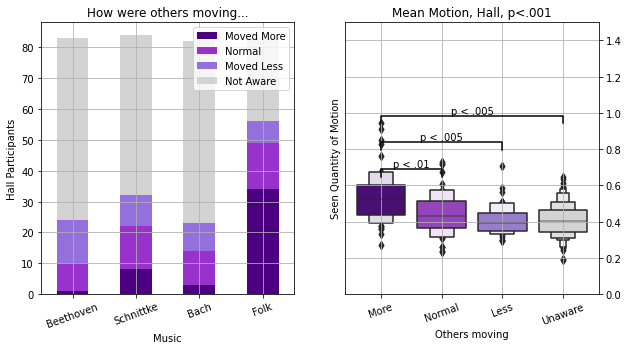

In [235]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']
response_order = ['Yes and they moved more than usual','Yes and they moved a normal amount','Yes and they moved less than usual',"Not aware of others' movement"]
my_pal = {'Yes and they moved more than usual':'indigo','Yes and they moved a normal amount':'darkorchid','Yes and they moved less than usual':'mediumpurple',"Not aware of others' movement":'lightgrey'}
short_responses = ['More','Normal','Less','Unaware']
tag_m = 'Motion_seen'

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and they moved more than usual':'Moved More','Yes and they moved a normal amount':'Normal','Yes and they moved less than usual':'Moved Less',"Not aware of others' movement":'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
#ax1.legend()
ax1.grid()
#ax1.tick_params(axis='x',labelrotation=20)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Hall Participants')
ax1.set_xlabel('Music')
ax1.set_xticklabels(tracks,rotation='20')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
k = 0
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3],(0.9-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.01,:]
ac = ac.loc[ac.pval>=0.01,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .01',[0,1,2,3],(0.9-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3],(0.9-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1

ax2.set_ylabel('Seen Quantity of Motion')
ax2.set_xticklabels(short_responses,rotation='20')
ax2.yaxis.tick_right()
ax2.set_xlabel('Others moving')
ax2.set_title('Mean Motion, Hall, p<.001')
ax2.set_ylim([0,1.5])
ax2.grid()
plt.savefig('./Plots/others_move_A_R_qom_big.png',bbox_inches = 'tight',dpi = 300)
plt.show()


                Source  ddof1      ddof2         F     p-unc       np2
0  aware_others_moving      3  87.663219  11.98378  0.000001  0.166302
                                    A                                   B  \
0       Not aware of others' movement  Yes and they moved a normal amount   
1       Not aware of others' movement  Yes and they moved less than usual   
2       Not aware of others' movement  Yes and they moved more than usual   
3  Yes and they moved a normal amount  Yes and they moved less than usual   
4  Yes and they moved a normal amount  Yes and they moved more than usual   
5  Yes and they moved less than usual  Yes and they moved more than usual   

    mean(A)   mean(B)      diff        se         T         df      pval  \
0  0.409257  0.447574 -0.038317  0.019051 -2.011288  58.127771  0.195687   
1  0.409257  0.409986 -0.000729  0.015037 -0.048465  57.423472  0.999959   
2  0.409257  0.541125 -0.131868  0.022747 -5.797204  51.746986  0.000002   
3  0.447574  0

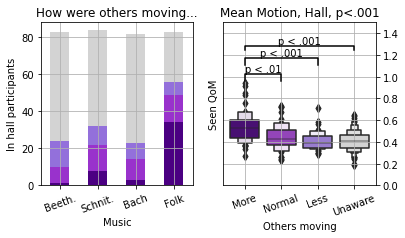

In [239]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']
response_order = ['Yes and they moved more than usual','Yes and they moved a normal amount','Yes and they moved less than usual',"Not aware of others' movement"]
my_pal = {'Yes and they moved more than usual':'indigo','Yes and they moved a normal amount':'darkorchid','Yes and they moved less than usual':'mediumpurple',"Not aware of others' movement":'lightgrey'}
short_responses = ['More','Normal','Less','Unaware']

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and they moved more than usual':'Moved More','Yes and they moved a normal amount':'Normal','Yes and they moved less than usual':'Moved Less',"Not aware of others' movement":'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1,legend=False)
#ax1.legend()
ax1.grid()
#ax1.tick_params(axis='x',labelrotation=20)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')
ax1.set_xticklabels(tracks_tag,rotation='20')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.001,:]
ac = ac.loc[ac.pval>=0.001,:].copy()
k = 0
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .001',[0,1,2,3],(1.2-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3],(1.2-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.01,:]
ac = ac.loc[ac.pval>=0.01,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .01',[0,1,2,3],(1.2-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3],(1.2-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1

ax2.set_ylabel('Seen QoM')
ax2.set_xticklabels(short_responses,rotation='20')
ax2.yaxis.tick_right()
ax2.set_xlabel('Others moving')
ax2.set_title('Mean Motion, Hall, p<.001')
ax2.set_ylim([0,1.5])
ax2.grid()
plt.savefig('./Plots/others_move_A_R_qom.png',bbox_inches = 'tight',dpi = 300)
plt.show()


In [234]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of others' movement,Yes and they moved a normal amount,0.409257,0.447574,-0.038317,0.019051,-2.011288,58.127771,0.195687,-0.401354
1,Not aware of others' movement,Yes and they moved less than usual,0.409257,0.409986,-0.000729,0.015037,-0.048465,57.423472,0.999959,-0.008380
2,Not aware of others' movement,Yes and they moved more than usual,0.409257,0.541125,-0.131868,0.022747,-5.797204,51.746986,0.000002,-1.300201
3,Yes and they moved a normal amount,Yes and they moved less than usual,0.447574,0.409986,0.037588,0.022530,1.668319,82.104007,0.346961,0.345931
4,Yes and they moved a normal amount,Yes and they moved more than usual,0.447574,0.541125,-0.093551,0.028265,-3.309772,86.000857,0.007333,-0.687128
5,Yes and they moved less than usual,Yes and they moved more than usual,0.409986,0.541125,-0.131139,0.025731,-5.096470,72.507308,0.000016,-1.066151


In [226]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of others' movement,Yes and they moved a normal amount,0.510752,0.558766,-0.048014,0.032993,-1.455251,64.517922,0.470231,-0.258478
1,Not aware of others' movement,Yes and they moved less than usual,0.510752,0.501666,0.009086,0.024111,0.376838,76.313306,0.981629,0.052868
2,Not aware of others' movement,Yes and they moved more than usual,0.510752,0.715365,-0.204613,0.041173,-4.969552,54.436279,0.000041,-1.031114
3,Yes and they moved a normal amount,Yes and they moved less than usual,0.558766,0.501666,0.057100,0.036372,1.569891,77.891990,0.401670,0.322686
4,Yes and they moved a normal amount,Yes and they moved more than usual,0.558766,0.715365,-0.156599,0.049364,-3.172338,83.831812,0.011155,-0.659409
5,Yes and they moved less than usual,Yes and they moved more than usual,0.501666,0.715365,-0.213699,0.043927,-4.864863,65.442264,0.000044,-1.009912


                Source  ddof1     ddof2         F     p-unc       np2
0  aware_others_moving      3  38.84186  2.889173  0.047655  0.049175
                Source  ddof1      ddof2        F     p-unc       np2
0  aware_others_moving      3  25.834165  1.24351  0.314308  0.054497


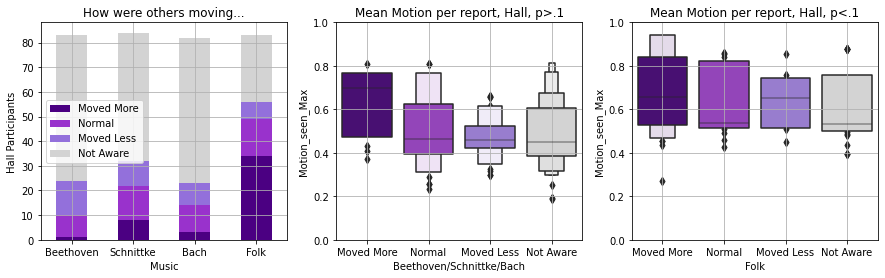

<Figure size 432x288 with 0 Axes>

In [227]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and they moved more than usual','Yes and they moved a normal amount','Yes and they moved less than usual',"Not aware of others' movement"]
my_pal = {'Yes and they moved more than usual':'indigo','Yes and they moved a normal amount':'darkorchid','Yes and they moved less than usual':'mediumpurple',"Not aware of others' movement":'lightgrey'}
short_responses = ['Moved More','Normal','Moved Less','Not Aware']

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and they moved more than usual':'Moved More','Yes and they moved a normal amount':'Normal','Yes and they moved less than usual':'Moved Less',"Not aware of others' movement":'Not Aware'},inplace=True)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
ax2.set_title('Mean Motion per report, Hall, p>.1')
ax2.set_ylim([0,1.0])
ax2.set_xticklabels(short_responses)
ax2.set_xlabel('Beethoven/Schnittke/Bach')
ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
ax3.set_title('Mean Motion per report, Hall, p<.1')
ax3.set_xticklabels(short_responses)
ax3.set_ylim([0,1.0])
ax3.set_xlabel('Folk')
ax3.grid()

plt.show()
plt.savefig('./Plots/others_move_A_R_qom_less.png',bbox_inches = 'tight',dpi = 300)



In [228]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Folk)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Not aware of others' movement,Yes and they moved a normal amount,0.616248,0.645856,-0.029608,0.063468,-0.466506,28.253209,0.965767,-0.151569
1,Not aware of others' movement,Yes and they moved less than usual,0.616248,0.639013,-0.022765,0.067763,-0.335957,11.865872,0.986280,-0.123056
2,Not aware of others' movement,Yes and they moved more than usual,0.616248,0.734579,-0.118331,0.060929,-1.942119,55.418688,0.222651,-0.482324
3,Yes and they moved a normal amount,Yes and they moved less than usual,0.645856,0.639013,0.006843,0.076251,0.089740,15.456156,0.999729,0.035564
4,Yes and they moved a normal amount,Yes and they moved more than usual,0.645856,0.734579,-0.088722,0.070248,-1.262986,36.953938,0.591705,-0.342287
5,Yes and they moved less than usual,Yes and they moved more than usual,0.639013,0.734579,-0.095565,0.074151,-1.288787,16.240297,0.582490,-0.359981


In [229]:
pwd

'/Users/finn/Desktop/Current_Projects/Copen/CopenML_Analysis'